In [1]:
import yfinance as yf

# List of Indian stock tickers you want to analyze. I'm using some example tickers here.
tickers = ["RELIANCE.NS", "TATAMOTORS.NS", "INFY.NS", "HDFCBANK.NS", "SUNPHARMA.NS", "ITC.NS", "BHARTIARTL.NS", "ULTRACEMCO.NS", "ADANIPORTS.NS", "TATASTEEL.NS"]


# Downloading data for the last 10 years
stock_data = yf.download(tickers, start="2013-08-01", end="2023-08-01")['Adj Close']
print(stock_data.head())


[*********************100%%**********************]  10 of 10 completed
            ADANIPORTS.NS  BHARTIARTL.NS  HDFCBANK.NS     INFY.NS      ITC.NS  \
Date                                                                            
2013-08-01     133.820694     298.510956   293.912903  287.875366  173.580002   
2013-08-02     118.914810     300.250244   293.471252  291.180267  170.281250   
2013-08-05     117.015961     292.510254   294.145386  291.204437  171.534271   
2013-08-06     123.472015     280.813324   282.964417  289.104401  168.900391   
2013-08-07     127.412140     283.726685   279.500885  286.781769  164.732208   

            RELIANCE.NS  SUNPHARMA.NS  TATAMOTORS.NS  TATASTEEL.NS  \
Date                                                                 
2013-08-01   396.538391    529.998352     283.667755      7.197430   
2013-08-02   399.967224    517.826843     285.140320      6.930287   
2013-08-05   401.926544    512.510559     279.544525      7.120370   
2013-08-06 

In [13]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

# Calculate the expected returns and the covariance matrix of daily returns
expected_returns = expected_returns.mean_historical_return(stock_data)
covariance_matrix = risk_models.sample_cov(stock_data)

# Create EfficientFrontier object
ef = EfficientFrontier(expected_returns, covariance_matrix)

# Maximize the Sharpe ratio
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

# Discrete allocation of shares
portfolio_val = 1000000  # Example portfolio value in INR
latest_prices = get_latest_prices(stock_data)
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=portfolio_val)
allocation, leftover = da.lp_portfolio()
print("Discrete Allocation:", allocation)
print("Funds Remaining: ₹{:.2f}".format(leftover))

Discrete Allocation: {'ADANIPORTS.NS': 24, 'HDFCBANK.NS': 205, 'INFY.NS': 174, 'ITC.NS': 1, 'RELIANCE.NS': 77, 'TATASTEEL.NS': 1231, 'ULTRACEMCO.NS': 7}
Funds Remaining: ₹361.16


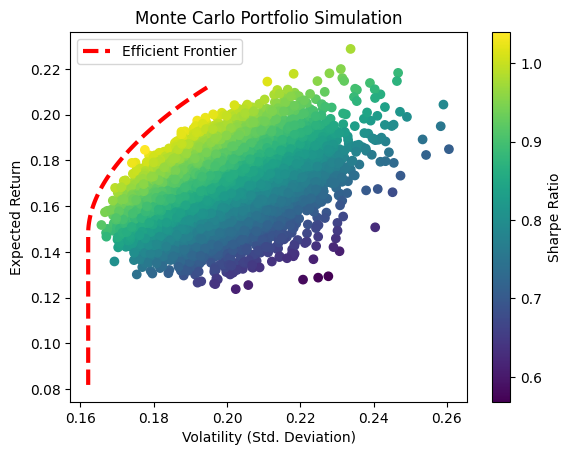

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Monte Carlo simulations to generate portfolios
num_portfolios = 10000
results = np.zeros((3, num_portfolios))
for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)
    portfolio_return = np.sum(weights * expected_returns)
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    results[0,i] = portfolio_return
    results[1,i] = portfolio_stddev
    results[2,i] = results[0,i] / results[1,i]

# Plot the portfolios
plt.scatter(results[1,:], results[0,:], c=results[2,:], marker='o')
plt.title('Monte Carlo Portfolio Simulation')
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')

# Plot Efficient Frontier
max_return, max_volatility, _ = ef.portfolio_performance()
target_returns = np.linspace(expected_returns.min(), max_return, 100)
target_risks = []
for target in target_returns:
    ef = EfficientFrontier(expected_returns, covariance_matrix)
    ef.efficient_return(target)
    target_risks.append(ef.portfolio_performance()[1])
plt.plot(target_risks, target_returns, 'r--', linewidth=3, label="Efficient Frontier")
plt.legend()
plt.show()

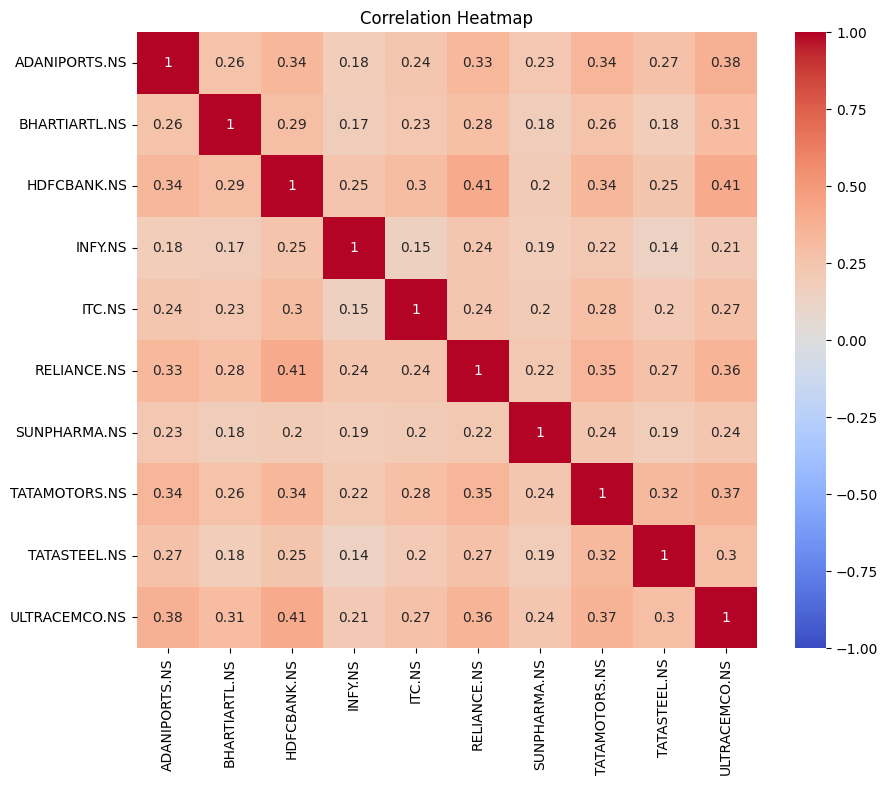

In [4]:
import seaborn as sns

correlation = stock_data.pct_change().corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

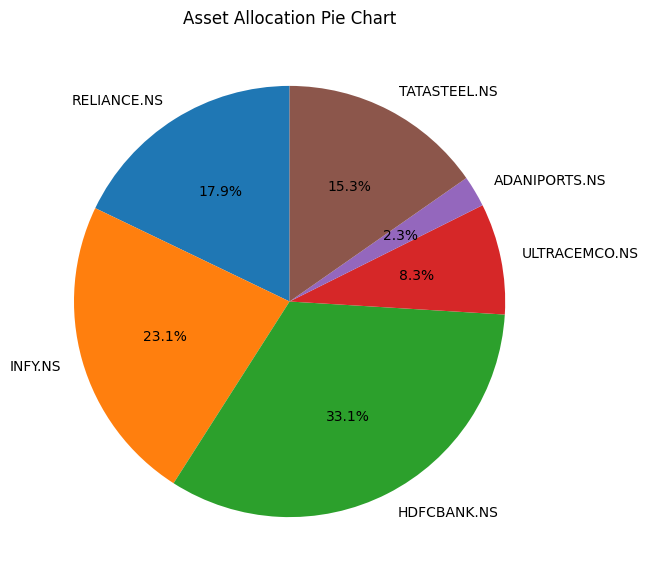

In [9]:
asset_allocation = [allocation[ticker]*latest_prices[ticker] for ticker in tickers if ticker in allocation]

# Also modify the labels to match the adjusted tickers
tickers_in_allocation = [ticker for ticker in tickers if ticker in allocation]

plt.figure(figsize=(10, 7))
plt.pie(asset_allocation, labels=tickers_in_allocation, autopct='%1.1f%%', startangle=90)
plt.title("Asset Allocation Pie Chart")
plt.show()

